In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax, numpyro, dill
from jax import config
import corner
import arviz as az
config.update("jax_enable_x64", True)
num_chains = 2
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 2


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True*0)

In [3]:
from vsiniutils import *

## hierarchical modeling using v samples

In [4]:
U = 10.
N = int(1e7)
u1, u2 = np.random.rand(N)*U, np.random.rand(N)*U
c1, c2 = np.random.rand(N), np.random.rand(N)
s1, s2 = np.sqrt(1-c1**2), np.sqrt(1-c2**2)
v1, v2 = u1/s1, u2/s2
x = np.log(v2/v1)

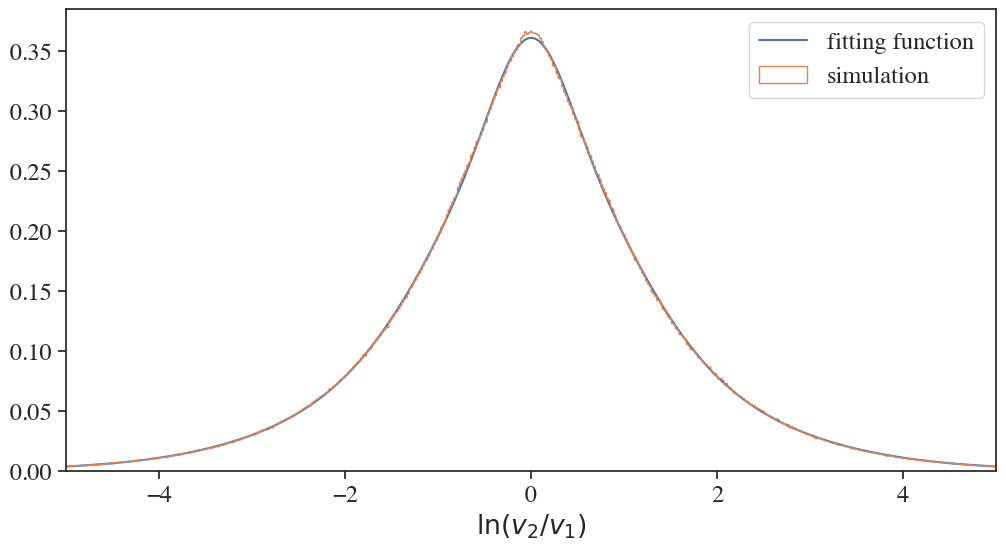

In [5]:
# prior for delta lnv
params_prior = np.loadtxt("../vsini/v_difference/params_prior_dlnv.txt")
bins = np.linspace(-10, 10, 1000)
plt.xlabel("$\ln(v_2/v_1)$")
plt.xlim(-5, 5)
plt.plot(bins, multinormalpdf(bins, params_prior), label='fitting function')
#plt.plot(bins, prior(bins), label='KDE')
plt.hist(x, density=True, bins=bins, histtype='step', lw=1, label='simulation')
plt.legend();

In [6]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
from jax.scipy.stats import norm

x0 = np.linspace(-3, 3, 1000)

def model_samples(xsmp, params_prior, fit_mu=False, mu_min=-2, mu_max=2., sigma_min=0, sigma_max=5):
    n_obj = jnp.shape(xsmp)[0]

    if fit_mu:
        mu = numpyro.sample("mu", dist.Uniform(mu_min, mu_max))
    else:
        mu = 0.
    sigma = numpyro.sample("sigma", dist.Uniform(sigma_min, sigma_max))

    loglike = jnp.sum(jnp.log(jnp.mean(norm.pdf(xsmp, loc=mu, scale=sigma)/multinormalpdf(xsmp, params_prior), axis=1)))
    numpyro.factor("loglike", loglike)

    numpyro.deterministic("pdf", norm.pdf(x0, loc=mu, scale=sigma))
    numpyro.deterministic("cdf", norm.cdf(x0, loc=mu, scale=sigma))

In [82]:
def run_simulation(sim, n_smp=2000):
    dlnvsmp, v1smp, _, _, _ = sim.get_v_samples(n_smp)    

    kernel = NUTS(model_samples)
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, dlnvsmp, params_prior)

    return mcmc, dlnvsmp, v1smp

def plot_cdf(samples, sim, dlnvsmp, name):
    plt.figure()
    cdf_mu, cdf_sig = np.mean(samples['cdf'], axis=0), np.std(samples['cdf'], axis=0)
    plt.plot(x0, cdf_mu, label='model')
    plt.xlim(-3, 3)
    plt.fill_between(x0, cdf_mu-cdf_sig, cdf_mu+cdf_sig, alpha=0.6)
    plt.hist(sim.dlnv, bins=x0, histtype='step', lw=3, cumulative=True, density=True, label='truth', color='gray')
    plt.hist(np.median(dlnvsmp, axis=1), bins=x0, histtype='step', lw=1, cumulative=True, density=True, label='posterior median', ls='dashed', color='tan');
    plt.xlabel("$\Delta\ln v$")
    plt.ylabel("CDF")
    plt.legend(loc='best')
    plt.savefig(f"{name}-cdf.png", dpi=200, bbox_inches="tight")

In [158]:
np.random.seed(124)
N, kappa, sigma_lnv, vsini_obserr = 100, 1e-3, 0.1, 1
#N, kappa, sigma_lnv, vsini_obserr = 100, 1e-3, 0.5, 1
#N, kappa, sigma_lnv, vsini_obserr = 20, 1e-3, 0.1, 1
#N, kappa, sigma_lnv, vsini_obserr = 20, 1e-3, 0.5, 1
vmu, vsigma = 50, 10
v_values = np.random.randn(N) * vsigma + vmu
sim = Simulate()

In [159]:
#simname = f"lognorm-v_iso-psi/N{N}_sigma{sigma_lnv:.2f}"
#sim.vsini_iso(N, sigma_lnv, v_values, vsini_obserr)

In [160]:
simname = f"lognorm-v_iso-psi/fisher_N{N}_sigma{sigma_lnv:.2f}"
sim.vsini_fisher(N, kappa, sigma_lnv, v_values, vsini_obserr, seed=124)

In [161]:
mcmc, dlnvsmp, v1smp = run_simulation(sim)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [162]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.54      0.08      0.54      0.42      0.66   1375.37      1.00

Number of divergences: 0


In [163]:
samples = mcmc.get_samples()

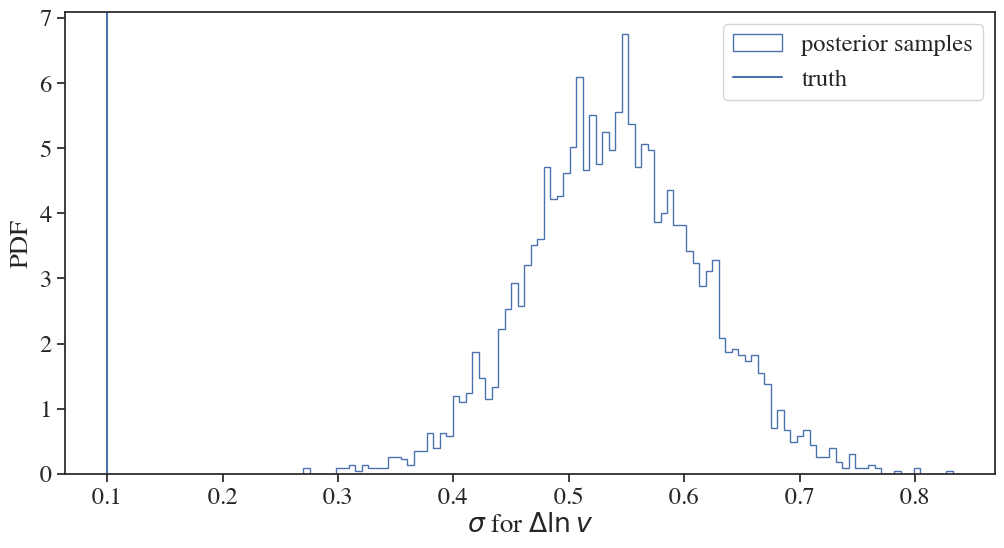

In [164]:
plt.hist(samples['sigma'], bins=100, density=True, histtype='step', lw=1, label='posterior samples')
plt.axvline(x=sigma_lnv, label='truth')
plt.xlabel("$\sigma$ for $\Delta \ln v$")
plt.ylabel("PDF")
plt.legend(loc='best')
plt.savefig(f"{simname}_vsamples.png", dpi=200, bbox_inches="tight")

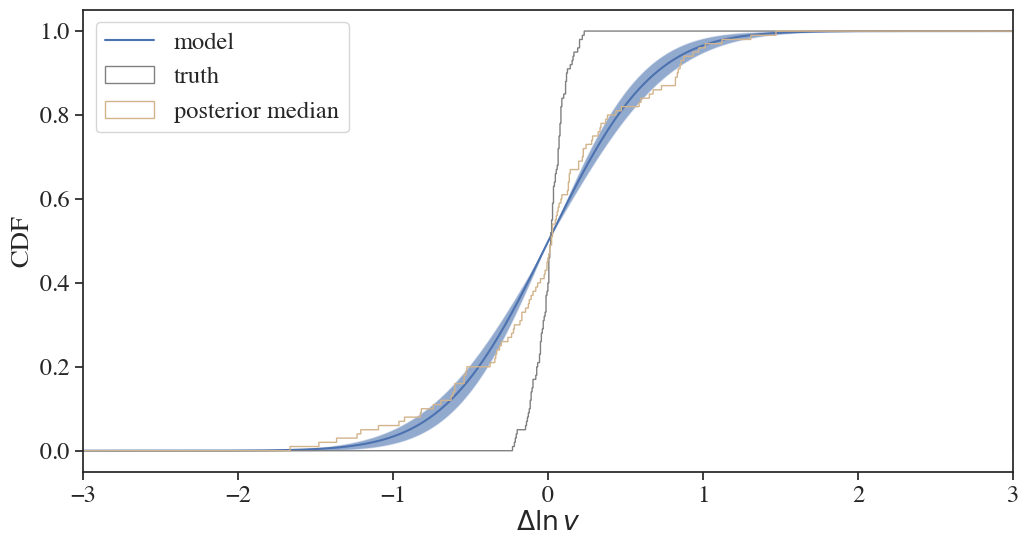

In [165]:
plot_cdf(samples, sim, dlnvsmp, f"{simname}_vsamples")

## full hierarchical modeling
- sample v1 of individual stars 
- assume gaussian likelihood for vsini
- model_vnormal: log-normal prior for v1 (i.e. true distribution used in the simulation)
- model_vlogu: log-uniform prior for v1

In [166]:
def model_vnormal(sim, fit_mu=False, vmin=3, vmax=300):
    vmu = numpyro.sample("vmu", dist.Uniform(vmin, vmax))
    logvsigma = numpyro.sample("logvsigma", dist.Uniform(jnp.log(0.03), jnp.log(30)))
    vsigma = numpyro.deterministic("vsigma", jnp.exp(logvsigma))

    logdlnvsigma = numpyro.sample("logdlnvsigma", dist.Uniform(jnp.log(0.01), jnp.log(1)))
    dlnvsigma = numpyro.deterministic("dlnvsigma", jnp.exp(logdlnvsigma))
    if fit_mu:
        dlnvmu = numpyro.sample("dlnvmu", dist.Uniform(-0.5, 0.5))
    else:
        dlnvmu = 0.
    with numpyro.plate("stars", sim.N):
        cosi1 = numpyro.sample("cosi1", dist.Uniform(0, 1))
        cosi2 = numpyro.sample("cosi2", dist.Uniform(0, 1))
        v1 = numpyro.sample("v1", dist.Normal(vmu, vsigma))
        dlnv = numpyro.sample("dlnv", dist.Normal(dlnvmu, dlnvsigma))
    
    v2 = numpyro.deterministic("v2", v1 * jnp.exp(dlnv))
    vsini1 = numpyro.deterministic("vsini1", v1 * jnp.sqrt(1-cosi1**2))
    vsini2 = numpyro.deterministic("vsini2", v2 * jnp.sqrt(1-cosi2**2))

    numpyro.sample("obs1", dist.Normal(vsini1, vsini_obserr), obs=sim.vsini1_obs)
    numpyro.sample("obs2", dist.Normal(vsini2, vsini_obserr), obs=sim.vsini2_obs)

    numpyro.deterministic("pdf", norm.pdf(x0, loc=dlnvmu, scale=dlnvsigma))
    numpyro.deterministic("cdf", norm.cdf(x0, loc=dlnvmu, scale=dlnvsigma))


def model_vlogu(sim, fit_mu=False, logunif=True, vmin=3, vmax=300):
    if logunif:
        logdlnvsigma = numpyro.sample("logdlnvsigma", dist.Uniform(jnp.log(0.01), jnp.log(1)))
        dlnvsigma = numpyro.deterministic("dlnvsigma", jnp.exp(logdlnvsigma))
    else:
        dlnvsigma = numpyro.sample("dlnvsigma", dist.Uniform(0, 1))
    if fit_mu:
        dlnvmu = numpyro.sample("dlnvmu", dist.Uniform(-0.5, 0.5))
    else:
        dlnvmu = 0.
    with numpyro.plate("stars", sim.N):
        cosi1 = numpyro.sample("cosi1", dist.Uniform(0, 1))
        cosi2 = numpyro.sample("cosi2", dist.Uniform(0, 1))
        logv1 = numpyro.sample("logv1", dist.Uniform(jnp.log(vmin), jnp.log(vmax)))
        dlnv = numpyro.sample("dlnv", dist.Normal(dlnvmu, dlnvsigma))
    
    v1 = numpyro.deterministic("v1", jnp.exp(logv1))
    v2 = numpyro.deterministic("v2", v1 * jnp.exp(dlnv))
    vsini1 = numpyro.deterministic("vsini1", v1 * jnp.sqrt(1-cosi1**2))
    vsini2 = numpyro.deterministic("vsini2", v2 * jnp.sqrt(1-cosi2**2))

    numpyro.sample("obs1", dist.Normal(vsini1, vsini_obserr), obs=sim.vsini1_obs)
    numpyro.sample("obs2", dist.Normal(vsini2, vsini_obserr), obs=sim.vsini2_obs)

    numpyro.deterministic("pdf", norm.pdf(x0, loc=dlnvmu, scale=dlnvsigma))
    numpyro.deterministic("cdf", norm.cdf(x0, loc=dlnvmu, scale=dlnvsigma))

In [167]:
def run_model(model, sim, simname, **model_kwargs):
    if model_kwargs is None:
        model_kwargs = {}
    kernel = NUTS(model) 
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, sim, **model_kwargs)
    mcmc.print_summary()
    samples = mcmc.get_samples()

    if 'vmu' in samples.keys():
        var_names = ["dlnvsigma", "vmu", "vsigma"]
        truths = [sigma_lnv, vmu, vsigma]
    else:
        var_names = ["dlnvsigma"]
        truths = [sigma_lnv]

    if 'fit_mu' in model_kwargs.keys():
        var_names = ['dlnvmu'] + var_names
        truths = [0] + truths

    fig = corner.corner(az.from_numpyro(mcmc), var_names=var_names, 
                       truths=truths, show_titles=True)
    plt.savefig(f"{simname}.png", dpi=200, bbox_inches="tight")
    
    plot_cdf(samples, sim, dlnvsmp, simname)

    return mcmc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosi1[0]      0.28      0.18      0.26      0.00      0.53   2233.83      1.00
      cosi1[1]      0.51      0.20      0.53      0.21      0.84   1847.63      1.00
      cosi1[2]      0.54      0.24      0.60      0.14      0.87   2661.25      1.00
      cosi1[3]      0.23      0.15      0.21      0.00      0.44   2315.61      1.00
      cosi1[4]      0.55      0.24      0.61      0.15      0.89   2153.80      1.00
      cosi1[5]      0.44      0.23      0.47      0.05      0.76   2386.04      1.00
      cosi1[6]      0.37      0.21      0.37      0.02      0.67   2095.75      1.00
      cosi1[7]      0.27      0.15      0.26      0.00      0.48   1022.65      1.00
      cosi1[8]      0.23      0.16      0.20      0.00      0.46   2231.80      1.00
      cosi1[9]      0.40      0.22      0.42      0.03      0.72   2503.44      1.00
     cosi1[10]      0.73      0.18      0.78      0.48      0.94

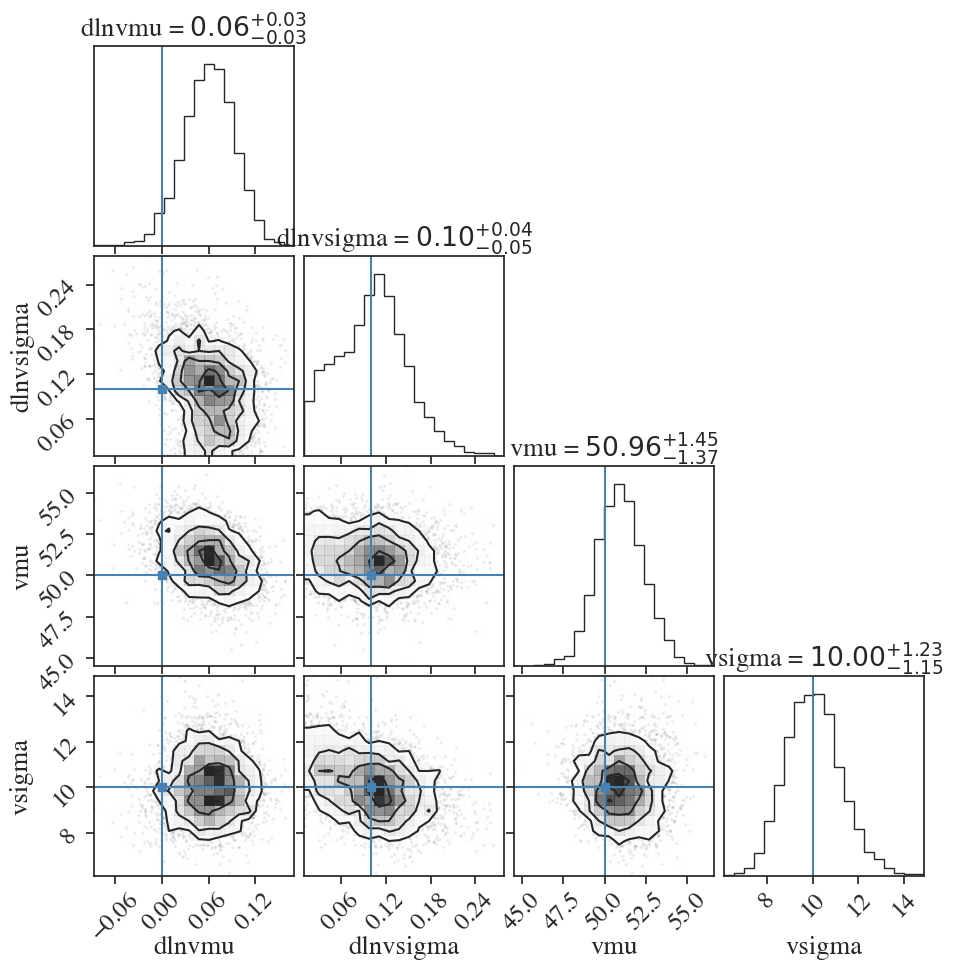

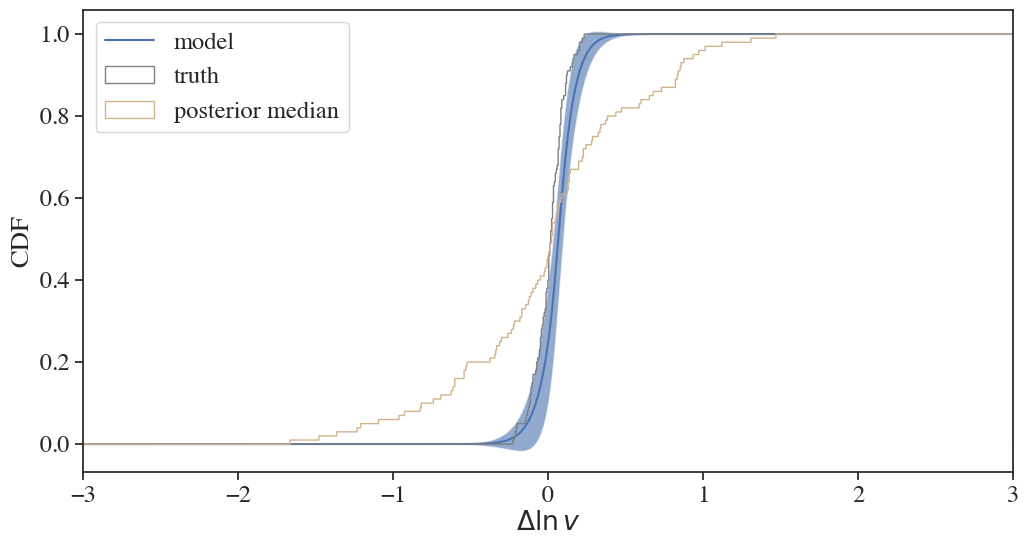

In [168]:
mcmc = run_model(model_vnormal, sim, simname=f"{simname}_vnormal", fit_mu=True)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosi1[0]      0.36      0.24      0.33      0.00      0.70   2406.10      1.00
      cosi1[1]      0.52      0.20      0.53      0.17      0.86    824.19      1.01
      cosi1[2]      0.37      0.25      0.35      0.00      0.72   2085.44      1.00
      cosi1[3]      0.35      0.22      0.33      0.00      0.68   1105.09      1.01
      cosi1[4]      0.36      0.24      0.33      0.00      0.70   2140.46      1.00
      cosi1[5]      0.37      0.24      0.34      0.00      0.72   2626.00      1.00
      cosi1[6]      0.34      0.23      0.31      0.00      0.67   2597.47      1.00
      cosi1[7]      0.50      0.19      0.51      0.19      0.85    911.49      1.00
      cosi1[8]      0.37      0.24      0.35      0.00      0.72   2251.54      1.00
      cosi1[9]      0.36      0.24      0.33      0.00      0.72   2553.39      1.00
     cosi1[10]      0.56      0.19      0.58      0.26      0.89

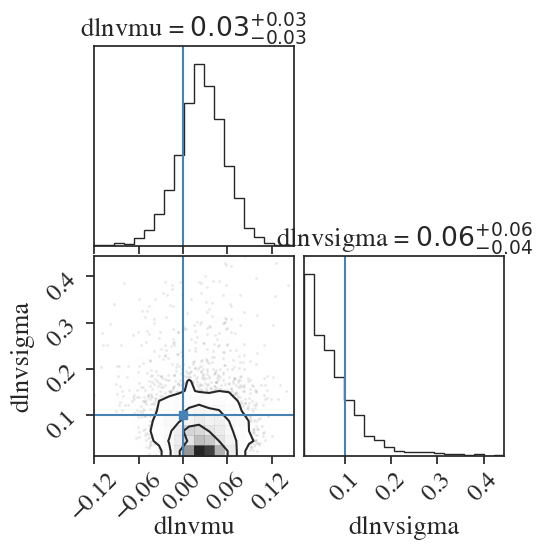

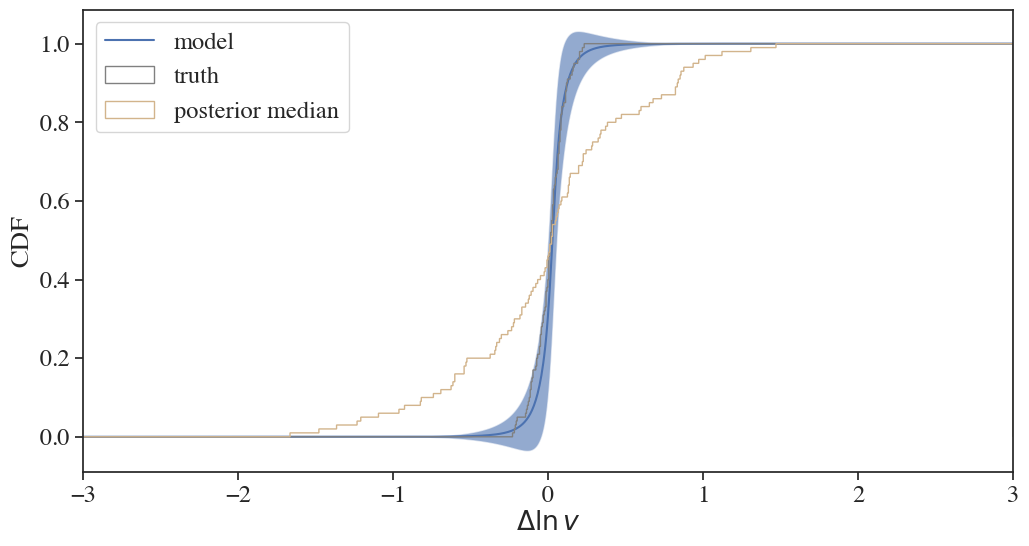

In [169]:
mcmc = run_model(model_vlogu, sim, simname=f"{simname}_vlogu", fit_mu=True)

## inference of v1 is also improved

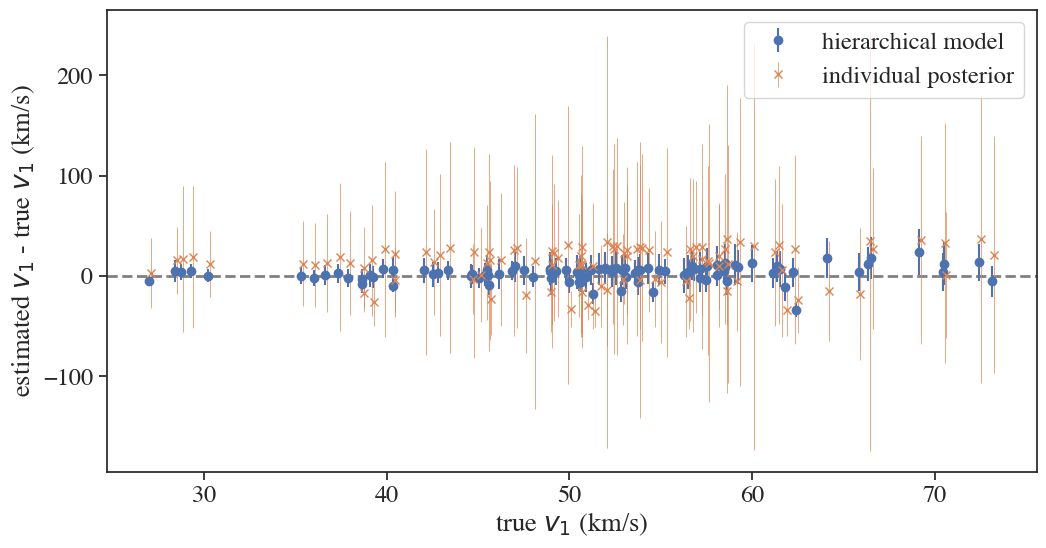

In [170]:
plt.axhline(y=0, color='gray', ls='dashed', lw=2)
plt.xlabel("true $v_1$ (km/s)")
plt.ylabel("estimated $v_1$ - true $v_1$ (km/s)")
plt.errorbar(sim.v1, np.mean(mcmc.get_samples()['v1'], axis=0)-sim.v1, fmt='o', yerr=np.std(mcmc.get_samples()['v1'], axis=0), label='hierarchical model');
plt.errorbar(sim.v1+0.1, np.mean(v1smp, axis=1)-sim.v1, fmt='x', yerr=np.std(v1smp, axis=1), lw=0.5, label='individual posterior')
plt.legend(loc='best');

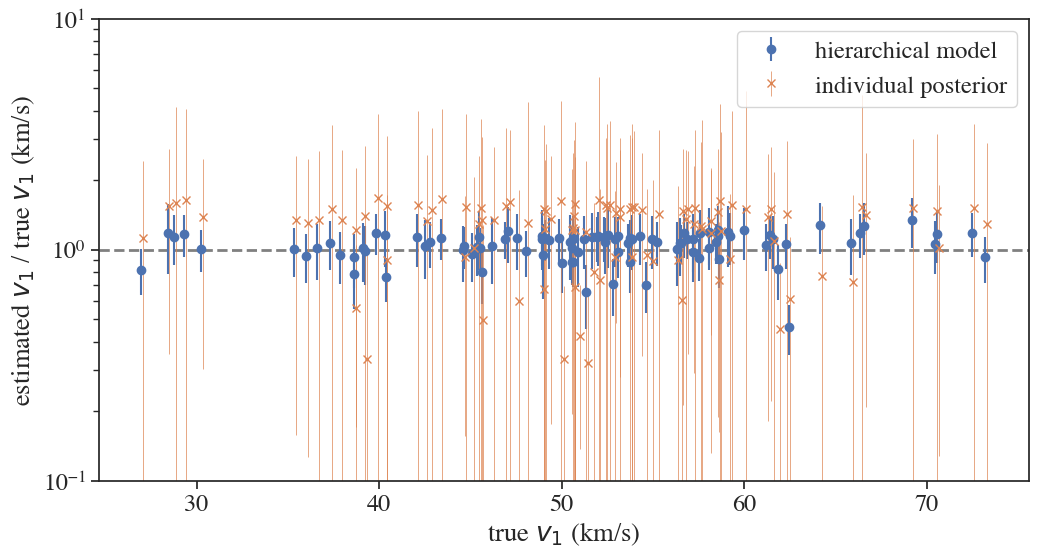

In [171]:
plt.axhline(y=1, color='gray', ls='dashed', lw=2)
plt.xlabel("true $v_1$ (km/s)")
plt.ylabel("estimated $v_1$ / true $v_1$ (km/s)")
plt.yscale("log")
plt.ylim(0.1, 10)
plt.errorbar(sim.v1, np.mean(mcmc.get_samples()['v1'], axis=0)/sim.v1, fmt='o', yerr=np.std(mcmc.get_samples()['v1']/sim.v1, axis=0), label='hierarchical model');
plt.errorbar(sim.v1+0.1, np.mean(v1smp, axis=1)/sim.v1, fmt='x', yerr=np.std(v1smp, axis=1)/sim.v1, lw=0.5, label='individual posterior')
plt.legend(loc='best');